# DATA PREPARATION

In [1]:
import pysal
import numpy
import scipy
import pandas
import random
import shapefile as shp
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn import preprocessing

%matplotlib inline
plt.style.use('ggplot')
pandas.set_option('display.max_rows', 100, "display.max_columns", 100)

In [2]:
db_blocks_groups = pysal.open('./dataset/Data/CLT_BlockGroups_Attr.dbf','r')
df_blocks_groups = pandas.DataFrame(db_blocks_groups[:], columns=db_blocks_groups.header)

db_blocks = pysal.open('./dataset/Data/CLT_Blocks_Attr.dbf','r')
df_blocks = pandas.DataFrame(db_blocks[:], columns=db_blocks.header)

db_business = pysal.open('./dataset/Data/CLT_Business_Attri.dbf','r')
df_business = pandas.DataFrame(db_business[:], columns=db_business.header)

db_crimes = pysal.open('./dataset/Data/CrimeIncident_CMPD_2010.dbf','r')
df_crimes = pandas.DataFrame(db_crimes[:], columns=db_crimes.header)

---
### Adding census stats 
Attaching related census stats for every block (when available)

In [3]:
# add column in crime dataframe for BLOCKID10 - taken from busine dataframe
# add "not found" where BLOCKID10 could not be found
street2block = df_business.set_index('ST_NAME')["Block_id"].to_dict()
df_crimes["BLOCKID10"] = df_crimes["Street_Nam"].map(lambda street: street2block.get(street, "not found"))
df_crimes.shape

(67595, 54)

In [4]:
# remove rows where BLOCKID10 is "not found"
df_crimes = df_crimes[df_crimes["BLOCKID10"] != "not found"]
df_crimes.shape

(50455, 54)

In [5]:
# adding df_blocks' and df_blocks_groups' columns of interest
census = {}
for index, row in df_blocks_groups.iterrows():
    census[str(row["GEOID10"])] = {
        "ARPCIncome": row["ARPCIncome"],
        "ARPerHEdu":  row["ARPerHEdu"],
        "ARPerWork":  row["ARPerWork"],
        "ARPerRMI5L": row["ARPerRMI5L"],
        "ARPer3MU":   row["ARPer3MU"]}

for index, row in df_blocks.iterrows():
    census[str(row["BLOCKID10"])] = {
        "ARPopDen":   row["ARPopDen"],
        "ARPerAA":    row["ARPerAA"],
        "ARHeteInx":  row["ARHeteInx"],
        "ARPerM1724": row["ARPerM1724"],
        "ARPerHOwn":  row["ARPerHOwn"],
        "ARPerSF":    row["ARPerSF"]}

    
get_group_census = lambda col: lambda block_id: census.get(block_id[0:12], {}).get(col, "NF")
get_block_census = lambda col: lambda block_id: census.get(block_id, {}).get(col, "NF")

df_crimes["ARPCIncome"] = df_crimes["BLOCKID10"].map(get_group_census("ARPCIncome"))
df_crimes["ARPerHEdu"]  = df_crimes["BLOCKID10"].map(get_group_census("ARPerHEdu"))
df_crimes["ARPerWork"]  = df_crimes["BLOCKID10"].map(get_group_census("ARPerWork"))
df_crimes["ARPerRMI5L"] = df_crimes["BLOCKID10"].map(get_group_census("ARPerRMI5L"))
df_crimes["ARPer3MU"]   = df_crimes["BLOCKID10"].map(get_group_census("ARPer3MU"))

df_crimes["ARPopDen"]   = df_crimes["BLOCKID10"].map(get_block_census("ARPopDen"))
df_crimes["ARPerAA"]    = df_crimes["BLOCKID10"].map(get_block_census("ARPerAA"))
df_crimes["ARHeteInx"]  = df_crimes["BLOCKID10"].map(get_block_census("ARHeteInx"))
df_crimes["ARPerM1724"] = df_crimes["BLOCKID10"].map(get_block_census("ARPerM1724"))
df_crimes["ARPerHOwn"]  = df_crimes["BLOCKID10"].map(get_block_census("ARPerHOwn"))
df_crimes["ARPerSF"]    = df_crimes["BLOCKID10"].map(get_block_census("ARPerSF"))

df_crimes.shape

(50455, 65)

In [6]:
# removing all rows that don't have census attributes
# because some BLOCKID10 don't exists in df_blocks and df_block_groups
df_temp = df_crimes[df_crimes["ARPopDen"] != "NF"]
df_crimes_and_census = df_temp[df_temp["ARPCIncome"] != "NF"]
df_crimes_and_census.shape

(19106, 65)

---
### Adding nearest K POI

In [7]:
# find nearest K business/POI for a crime
crime_points    = numpy.array(pysal.open('./dataset/Data/CrimeIncident_CMPD_2010.shp', 'r'))
business_points = numpy.array(pysal.open('./dataset/Data/CLT_Business_Attri.shp', 'r'))
mall_points     = numpy.array(pysal.open('./dataset/Data/POI_Malls.shp', 'r'))
walmart_points  = numpy.array(pysal.open("./dataset/Data/POI_WALMART.shp", 'r'))
drinking_points = numpy.array(pysal.open("./dataset/Data/POI_AlcoholicDrinkingPlaces_CLIP.shp", 'r'))
hotels_points   = numpy.array(pysal.open("./dataset/Data/POI_HotelsMotels.shp", 'r'))
park_points     = numpy.array(pysal.open("./dataset/Data/POI_ParknRideFacilities.shp", 'r'))

business_name = [row["TradeName"] for i, row in df_business.iterrows()]
mall_name     = ["mall" for i in mall_points]
walmart_name  = ["walmart" for i in walmart_points]
drinking_name = ["drinking" for i in drinking_points]
hotels_name   = ["hotels" for i in hotels_points]
park_name     = ["park" for i in park_points]

names  = business_name + mall_name + walmart_name + drinking_name + hotels_name + park_name
points = numpy.concatenate((business_points, mall_points, walmart_points,
                            drinking_points, hotels_points, park_points))

In [8]:
# closest_POI -> for each crime its neighbourhood
closest_POI = []
k_closest = 5
kd_tree = scipy.spatial.cKDTree(points, leafsize=100)
for point in crime_points:
    neighborhood = kd_tree.query(point, k=k_closest)
    closest_POI.append( [str(names[neighbor]) for neighbor in neighborhood[1]] )


In [9]:
# adding closestPOI to df 
for i, row in df_crimes_and_census.iterrows():
    df_crimes_and_census.set_value(i,'First_POI', closest_POI[i][0])
    df_crimes_and_census.set_value(i,'Second_POI', closest_POI[i][1])
    df_crimes_and_census.set_value(i,'Third_POI', closest_POI[i][2])
    df_crimes_and_census.set_value(i,'Fourth_POI', closest_POI[i][3])
    df_crimes_and_census.set_value(i,'Fifth_POI', closest_POI[i][4])

df_crimes_and_census.shape

(19106, 70)

---
###  Removing useless columns

In [10]:
# keeping only some crimes' columns
col2keep = [
    "BLOCKID10",    # block ID
    "First_POI",    # first closest POI
    "Second_POI",   # second closest POI
    "Third_POI",    # third closest POI
    "Fourth_POI",   # fourth closest POI
    "Fifth_POI",    # fifth closest POI
    "ARPCIncome",   # percapital Income; type: real, length 18
    "ARPerHEdu",    # percentage of education with high school and above
    "ARPerWork",    # percentage of population employed
    "ARPerRMI5L",   # percentage of population who rent and moved in less than 5 years ago
    "ARPer3MU",     # percentage of home with 3 or more multiple unit structure
    "ARPopDen",     # population density; type: real, length 18
    "ARPerAA",      # percentage of population who are American African
    "ARHeteInx",    # heterogeneity index for races
    "ARPerM1724",   # percentage of population who are 17-24 males
    "ARPerHOwn",    # percentage of population who own home
    "ARPerSF",      # percentage of families with single parent
    "NIBRSclass",   # type of crime i guess
    "Attempt",      # completed, ecc
    "Case_Statu",   # further investigation, close/cleared, ecc
    "Clearance_",   # open, normal clearance/cleared by arrest, ecc
    "Place1",       # residential, open area, commercial place, retail
    "Place2",       # private residence, street/highway, ecc
    "Location_T",   # indoors or outdoors
    "Report_Dat",   # date
    "Street_Nam"    # street
]

df_crimes_and_census = df_crimes_and_census[col2keep]
df_crimes_and_census.shape

(19106, 26)

In [11]:
df_crimes_and_census[:3]

,BLOCKID10,First_POI,Second_POI,Third_POI,Fourth_POI,Fifth_POI,ARPCIncome,ARPerHEdu,ARPerWork,ARPerRMI5L,ARPer3MU,ARPopDen,ARPerAA,ARHeteInx,ARPerM1724,ARPerHOwn,ARPerSF,NIBRSclass,Attempt,Case_Statu,Clearance_,Place1,Place2,Location_T,Report_Dat,Street_Nam
0,371190032011003,CHARLOTTE WOOD APARTMENTS,CAROLINA FIRST AID & SAFETY,WILDWOOD APARTMENTS,MT ZION HOLINESS CHURCH,KHL DESIGNS,23826,22.5136,93.0147,30.6122,20.3501,0.000151339,7.42574,0.549505,8.91089,14,38,Simple Assault,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Residential,Apartment/Duplex Private Res,Indoors,01/01/2010 0005,SCALEYBARK
12,371190015041006,UNITED TREATMENT FACILITY,LINKS AT CITI SIDE,STRAIGHT LINE PAVEMENT MARKING,JAMES D MCDUFFIE AGENT,MIDLAND NATIONAL INSURANCE CO,17393,14.6895,80.3054,28.8553,28.1577,0.00013986,54.1667,0.53125,0,72.7273,36.3636,Simple Assault,Completed,Close/Cleared,Exceptionally Cleared - Victim Chose not to Pr...,Residential,Apartment/Duplex Private Res,Outdoors,01/01/2010 0110,CITISIDE
15,371190001001020,hotels,OMNI CHARLOTTE HOTEL,ILLUM'E,THE RITZ CARLTON HOTEL COMPANY LLC,JONES LANG LASALLE AMERICAS INC,106794,3.0888,100,74.4681,88.9145,0,0,0,0,0,0,Weapon Law Violations,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Open Area,Street/Highway,Outdoors,01/01/2010 0118,COLLEGE


In the following we show some simple statistic about each variable:
- **Count**: Describes the number of not null values;
- **Unique**: Describes the number of unique values;
- **Top**: Describes the mode (in the case of multiple mode only one is shown)
- **Freq**: Describe the frequency of the returned top value


In [12]:
df_crimes_and_census.describe()

,BLOCKID10,First_POI,Second_POI,Third_POI,Fourth_POI,Fifth_POI,ARPCIncome,ARPerHEdu,ARPerWork,ARPerRMI5L,ARPer3MU,ARPopDen,ARPerAA,ARHeteInx,ARPerM1724,ARPerHOwn,ARPerSF,NIBRSclass,Attempt,Case_Statu,Clearance_,Place1,Place2,Location_T,Report_Dat,Street_Nam
count,19106,19106,19106,19106,19106,19106,19106.0,19106.000000,19106.000000,19106.000000,19106.0,19106.0,19106.0,19106.0,19106.0,19106.0,19106.0,19106,19106,19106,19106,19106,19106,19106,19106,19106
unique,741,3814,3952,4081,4340,4405,181.0,180.000000,180.000000,168.000000,153.0,623.0,385.0,463.0,287.0,297.0,275.0,52,2,4,10,5,67,5,18673,1094
top,371190047001015,MARMI,hotels,BILLY REID,LENSCRAFTERS,CARLYLE & COMPANY,18560.0,13.170732,71.957295,36.824697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Theft From Motor Vehicle,Completed,Inactive,Open,Residential,Private Residence,Indoors,05/01/2010 1631,TRADE
freq,787,215,312,215,215,215,1058.0,1058.000000,1058.000000,1058.000000,1591.0,5727.0,7570.0,7663.0,9086.0,6868.0,7044.0,2523,18413,9803,11520,8414,3950,8451,3,787


In [13]:
df_crimes_and_census.replace(0, numpy.nan).describe()

,ARPCIncome,ARPerHEdu,ARPerWork,ARPerRMI5L,ARPer3MU,ARPopDen,ARPerAA,ARHeteInx,ARPerM1724,ARPerHOwn,ARPerSF
count,19106.000000,18550.000000,19106.000000,18785.000000,17515.000000,1.337900e+04,11536.000000,11443.000000,10020.000000,12238.000000,12062.000000
mean,32143.145295,13.654647,75.291682,41.441861,39.024404,1.732083e-04,51.646927,0.368186,5.923497,57.136425,27.696651
std,29527.596815,13.254983,12.646551,21.316652,27.910962,1.635689e-04,34.419660,0.203971,4.047635,30.217798,16.837132
min,6203.000000,0.554017,36.974790,0.721371,1.809211,3.699000e-07,0.490196,0.015872,0.371747,0.719424,0.628931
25%,12375.000000,7.037037,67.435897,25.912409,19.542421,8.250850e-05,15.789474,0.154481,3.225806,35.714286,12.500000
50%,18560.000000,11.480602,75.030750,40.944882,29.477021,1.334896e-04,53.846154,0.402042,5.263158,54.545455,28.542510
75%,41499.000000,13.636364,83.985765,57.195572,59.402985,1.998811e-04,86.486486,0.538108,8.333333,84.375000,38.000000
max,149122.000000,72.421525,100.000000,97.619048,97.300771,1.311533e-03,100.000000,0.752447,42.177914,100.000000,100.000000


---

### Discretization

##### Income, Density and Heterogeneity index

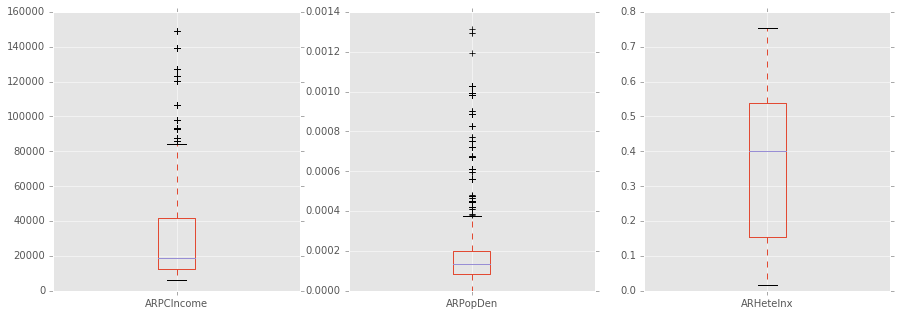

In [14]:
fig_size = [15, 5]
plt.rcParams["figure.figsize"] = fig_size

df_crimes_and_census[["ARPCIncome", "ARPopDen", "ARHeteInx"]].replace(0, numpy.nan).plot.box(subplots=True)
print ""

##### Some percentage

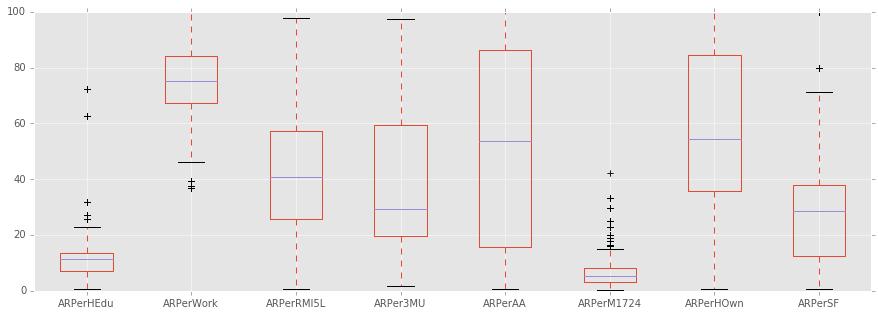

In [15]:
fig_size = [15, 5]
plt.rcParams["figure.figsize"] = fig_size
df_crimes_and_census[[
        "ARPerHEdu", "ARPerWork", "ARPerRMI5L", "ARPer3MU", 
        "ARPerAA", "ARPerM1724", "ARPerHOwn", "ARPerSF"]].replace(0, numpy.nan).plot.box()
print ""

In [16]:
label2discretize = lambda attr, n: [ attr + "-" + str(i) + "/" + str(n) for i in range(1, n + 1)]
print "Example of discretization in 5 parts: ", label2discretize("inc", 5)

Example of discretization in 5 parts:  ['inc-1/5', 'inc-2/5', 'inc-3/5', 'inc-4/5', 'inc-5/5']


In [17]:
df = df_crimes_and_census.copy()
num_bins = 7
df["ARPCIncome"] = pandas.qcut(df_crimes_and_census["ARPCIncome"], num_bins, 
    labels=label2discretize("inc", num_bins))

df["ARPerHEdu"]  = pandas.qcut(df_crimes_and_census["ARPerHEdu"], num_bins, 
    labels=label2discretize("edu", num_bins))

df["ARPerWork"]  = pandas.qcut(df_crimes_and_census["ARPerWork"], num_bins, 
    labels=label2discretize("empl", num_bins))

df["ARPerRMI5L"] = pandas.qcut(df_crimes_and_census["ARPerRMI5L"], num_bins, 
    labels=label2discretize("lt5y", num_bins))

df["ARPer3MU"]   = pandas.qcut(df_crimes_and_census["ARPer3MU"], num_bins, 
    labels=label2discretize("3mu", num_bins))


df["ARPopDen"]   = pandas.qcut(df_crimes_and_census["ARPopDen"].replace(0, numpy.nan), num_bins, 
    labels=label2discretize("popden", num_bins))

df["ARPerAA"]    = pandas.qcut(df_crimes_and_census["ARPerAA"].replace(0, numpy.nan), num_bins, 
    labels=label2discretize("afro", num_bins))

df["ARHeteInx"]  = pandas.qcut(df_crimes_and_census["ARHeteInx"].replace(0, numpy.nan), num_bins, 
    labels=label2discretize("hetero", num_bins))

df["ARPerM1724"] = pandas.qcut(df_crimes_and_census["ARPerM1724"].replace(0, numpy.nan), num_bins, 
    labels=label2discretize("youngm", num_bins))

df["ARPerHOwn"]  = pandas.qcut(df_crimes_and_census["ARPerHOwn"].replace(0, numpy.nan), num_bins, 
    labels=label2discretize("own", num_bins))

df["ARPerSF"]    = pandas.qcut(df_crimes_and_census["ARPerSF"].replace(0, numpy.nan), num_bins, 
    labels=label2discretize("sinpar", num_bins))


In [18]:
# leaving only the 3 ranges per month 
for i, row in df.iterrows():
    month = row["Report_Dat"][:2]
    day = row["Report_Dat"][3:4]
    new_val = month + "-" + ("2" if int(day) == 3 else str(day)) + "x"
    df.set_value(i,'Report_Dat', new_val)

In [19]:
# on second thoght it's better to remove other useless columns like [Case_Statu] [Place1]
# on third thought it's better to remove other useless columns like [Clearance_] [Location_T]
# i swear im gonna delete everything

df = df.drop(["Attempt", "Case_Statu", "Place1", "Clearance_", "Location_T"], axis=1)
df.shape

(19106, 21)

In [20]:
df.describe()

,BLOCKID10,First_POI,Second_POI,Third_POI,Fourth_POI,Fifth_POI,ARPCIncome,ARPerHEdu,ARPerWork,ARPerRMI5L,ARPer3MU,ARPopDen,ARPerAA,ARHeteInx,ARPerM1724,ARPerHOwn,ARPerSF,NIBRSclass,Place2,Report_Dat,Street_Nam
count,19106,19106,19106,19106,19106,19106,19106,19106,19106,19106,19106,13379,11536,11443,10020,12238,12062,19106,19106,19106,19106
unique,741,3814,3952,4081,4340,4405,7,7,7,7,7,7,7,7,7,7,7,52,67,36,1094
top,371190047001015,MARMI,hotels,BILLY REID,LENSCRAFTERS,CARLYLE & COMPANY,inc-1/7,edu-6/7,empl-1/7,lt5y-1/7,3mu-3/7,popden-5/7,afro-1/7,hetero-1/7,youngm-2/7,own-2/7,sinpar-1/7,Theft From Motor Vehicle,Private Residence,07-2x,TRADE
freq,787,215,312,215,215,215,2967,2828,3183,3077,3359,2149,1763,2315,1657,2074,1802,2523,3950,684,787


---
### Missing Values

In [21]:
# remove mv from block groups
df = df[df["ARPCIncome"] != 0]
df = df[df["ARPerHEdu"] != 0]
df = df[df["ARPerWork"] != 0]
df = df[df["ARPerRMI5L"] != 0]
df.drop(["ARPer3MU"], axis=1)
df.shape # (19106, 21)

(19106, 21)

In [22]:
df[["ARPopDen", "ARPerAA", "ARHeteInx", "ARPerM1724", "ARPerHOwn", "ARPerSF"]][:4].style.applymap(
    lambda val: 'color: %s' % ('red' if val != val else 'black'))

In [23]:
# predicting NaN values for {ARPopDen - ARPerAA - ARHeteInx - ARPerM1724 - ARPerHOwn - ARPerSF}
# using all other columns
columns_without_mv = [
    "BLOCKID10",    # block ID
    "First_POI",    # first closest POI
    "Second_POI",   # second closest POI
    "Third_POI",    # third closest POI
    "Fourth_POI",   # fourth closest POI
    "Fifth_POI",    # fifth closest POI
    "ARPCIncome",   # percapital Income; type: real, length 18
    "ARPerHEdu",    # percentage of education with high school and above
    "ARPerWork",    # percentage of population employed
    "ARPerRMI5L",   # percentage of population who rent and moved in less than 5 years ago
    "ARPer3MU",     # percentage of home with 3 or more multiple unit structure
    "NIBRSclass",   # type of crime i guess
    "Place2",       # private residence, street/highway, ecc
    "Report_Dat",   # date
    "Street_Nam"    # street
]

In [24]:
%%time

values_set = set()
for col in df:
    for elem in df[col].unique():
        values_set.add(elem)

encoder = preprocessing.LabelEncoder()
encoder.fit(list(values_set))

for col_to_predict in ["ARPopDen", "ARPerAA", "ARHeteInx", "ARPerM1724", "ARPerHOwn", "ARPerSF"]:
    sample_df = df[columns_without_mv + [col_to_predict]]
    sample_df.dropna(subset=[col_to_predict], inplace=True)
    
    target    = encoder.transform(sample_df[col_to_predict].tolist())
    sample_df = sample_df.drop(col_to_predict, axis=1)
    samples   = [encoder.transform(row.tolist()) for i, row in sample_df.iterrows()]
    
    classifier = tree.DecisionTreeClassifier()
    classifier.fit(samples, target)
    
    for i, row in df.iterrows():
        if row[col_to_predict] != row[col_to_predict]: # check if it's NaN
            prediction_encoded = classifier.predict([encoder.transform(row[columns_without_mv].tolist())])
            prediction_decoded = encoder.inverse_transform(prediction_encoded)
            df.set_value(i, col_to_predict, prediction_decoded)
    


/Users/chris/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


CPU times: user 10min 15s, sys: 46.8 s, total: 11min 2s
Wall time: 11min 14s


---
### Some fancy plot
very nice indeed

Crimes aggregated every ten days


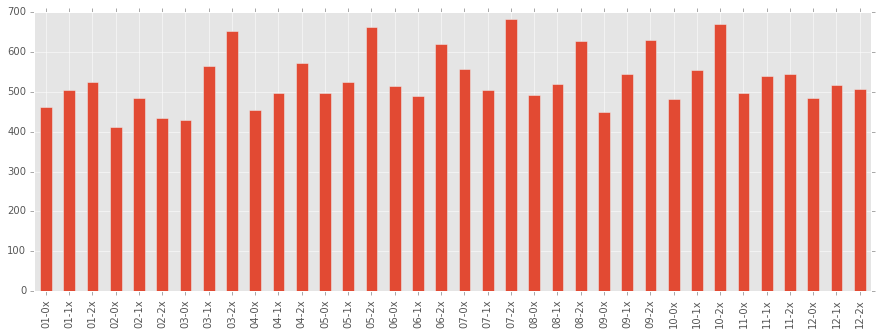

In [26]:
fig_size = [15, 5]
plt.rcParams["figure.figsize"] = fig_size

date_series = df["Report_Dat"].astype('category')
date_series = date_series.value_counts().sort_index()

pandas.Series(date_series).plot.bar()
print "Crimes aggregated every ten days"

Places


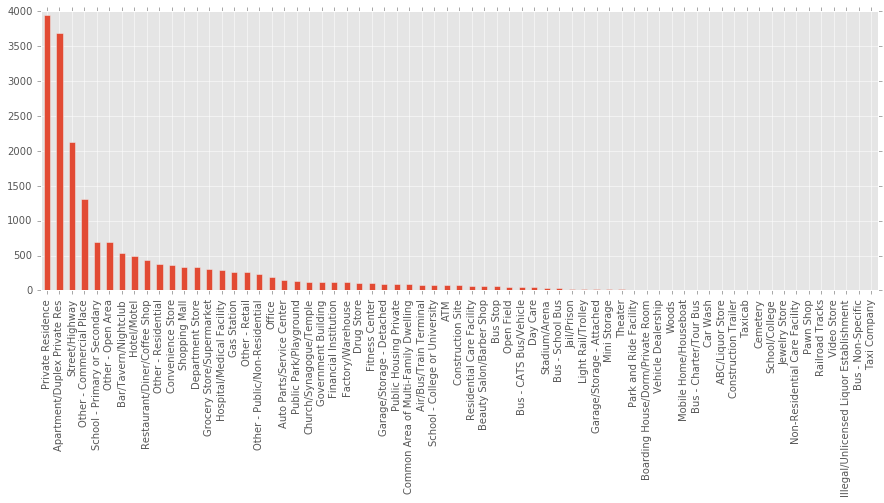

In [27]:
fig_size = [15, 5]
plt.rcParams["figure.figsize"] = fig_size

crime_place = df["Place2"].astype('category')
crime_place.value_counts().plot.bar()
print "Places"

Class


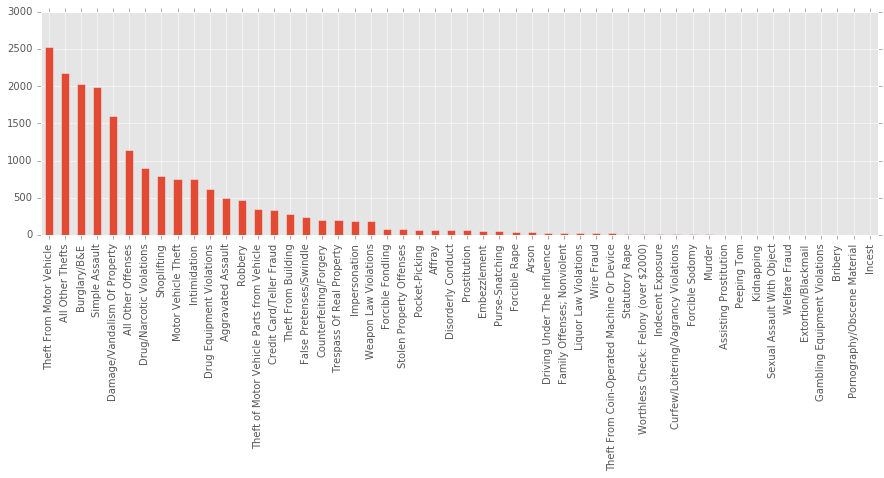

In [28]:
fig_size = [15, 4]
plt.rcParams["figure.figsize"] = fig_size

crime_class = df["NIBRSclass"].astype('category')
crime_class.value_counts().plot.bar()
print "Class"

In [29]:
df.to_csv("dataset/crimes_census_5poi.csv", sep='\t')

---
### Sampling

In [31]:
# on fourth thought a stratified sampling is a better idea 
# stratification based on crime classes [NIBRSclass]

In [32]:
# size for eache crime class
sample_size = 100
for col in df:
    df[col] = df[col].astype(object)

crimes_classes = set(df["NIBRSclass"].values)
# random.sample(range(0, len(df)), sample_size)

df_sampled = pandas.DataFrame(columns=df.columns)
for cls in crimes_classes:
    oneclass_df = df[df["NIBRSclass"] == cls].reset_index(drop=True)
    sampling_indexes = oneclass_df.index.tolist()
    if len(oneclass_df) >= 100:
        sampling_indexes = numpy.random.choice(range(len(oneclass_df)), sample_size, replace=False)
    df_sampled = pandas.concat([df_sampled, oneclass_df.ix[sampling_indexes]])

df_sampled.shape

(2954, 21)

In [33]:
df_sampled.to_csv("dataset/crimes_census_5poi_sampled100.csv", sep='\t')

Class sampled


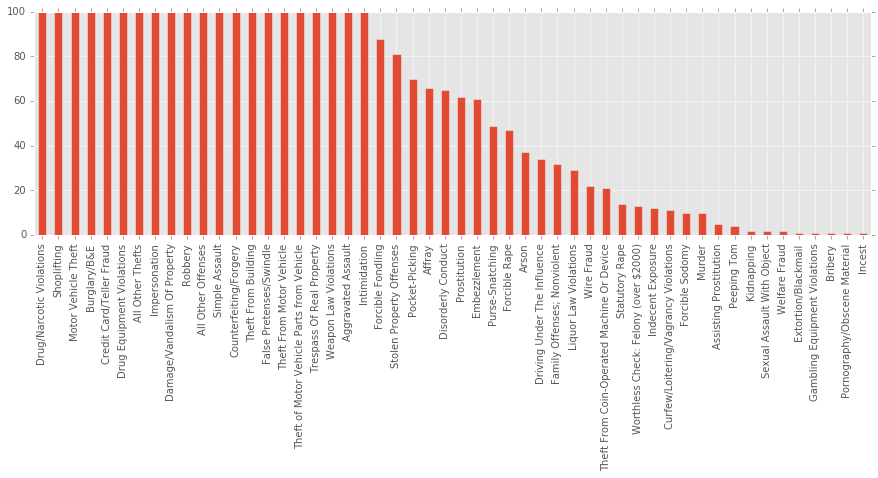

In [34]:
fig_size = [15, 4]
plt.rcParams["figure.figsize"] = fig_size

crime_class = df_sampled["NIBRSclass"].astype('category')
crime_class.value_counts().plot.bar()
print "Class sampled"

#### Distribution befor sampling

Distribution befor sampling


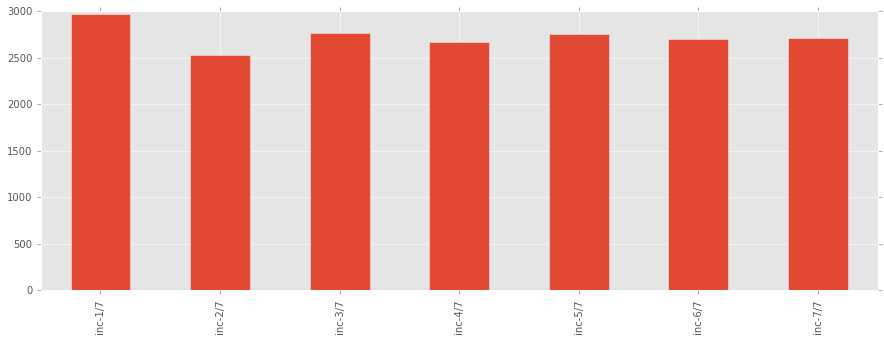

In [30]:
fig_size = [15, 5]
plt.rcParams["figure.figsize"] = fig_size

date_series = df["ARPCIncome"].astype('category')
date_series = date_series.value_counts().sort_index()

pandas.Series(date_series).plot.bar()
print "Distribution befor sampling"

### Distribution after sampling

Crimes aggregated every ten days


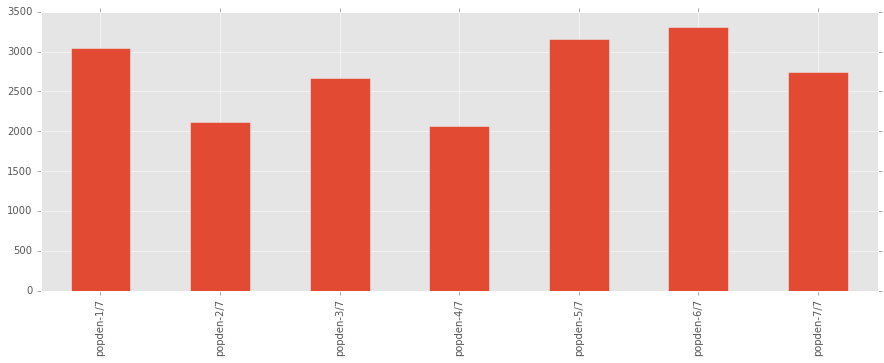

In [36]:
fig_size = [15, 5]
plt.rcParams["figure.figsize"] = fig_size

date_series = df["ARPopDen"].astype('category')
date_series = date_series.value_counts().sort_index()

pandas.Series(date_series).plot.bar()
print "Crimes aggregated every ten days"